<h2>Plotting Vertical Cross-Sections</h2>

These plots do not rely on any map projection; however, they require interpolating the data from the model's vertical grid to a user-specified vertical grid (here, pressure levels). The example below plots a vertical cross-section (between 1000-100 hPa) of wind speed and potential temperature through Hurricane Matthew valid at 0000 UTC 8 October 2016, using data obtained from the Assignment 1 tutorial case.

This example was drawn from the Vertical Cross-Section example in the wrf-python Plotting Examples gallery (https://wrf-python.readthedocs.io/en/latest/plot.html#vertical-cross-section) with tweaks so that the vertical coordinate is pressure rather than height. More information on how to use wrf-python is available at https://wrf-python.readthedocs.io/en/main/basic_usage.html.

<hr>

We start by importing the needed modules. These are drawn from four packages - netCDF4, matplotlib, numpy, and wrf (short for wrf-python). We do not need to load cartopy because there is no mapping involved.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)
from netCDF4 import Dataset
from wrf import to_np, getvar, CoordPair, vertcross

Open the desired wrfout file (which in this instance contains data for only a single output time).

In [8]:
ncfile = Dataset("wrfout_d01_2016-10-08_00:00:00")

Extract the 3-D model pressure, wind speed, and potential temperature. The first is in hPa by default; the middle is specified in kt; the last is specified in K. All are wrf-python derived variables.

The uvmet_wspd_dir function returns both speed and direction relative to the Earth. The wind speed is the 0th element of the first dimension and the wind direction is the 1th element of the first dimension. The second dimension is the 3-D data, which we obtain all of.

In [9]:
p = getvar(ncfile, "pressure")
wspd =  getvar(ncfile, "uvmet_wspd_wdir", units="kt")[0,:]
theta = getvar(ncfile, "theta", units="K")

Next, use the wrf-python CoordPair helper function to define the cross-section's start and end points. We could theoretically use metpy's vertical cross-section functionality (https://unidata.github.io/MetPy/latest/examples/cross_section.html), but we stick to wrf-python's functionality to avoid having to load another package and mix syntax. The points specified here were determined manually by looking at the plots created in the 2D and 3D Plotting Examples notebooks.

In [10]:
start_point = CoordPair(lat=32.5, lon=-84.0)
end_point = CoordPair(lat=28.0, lon=-78.5)

Finally, we compute the vertical cross-section interpolations using wrf-python's vertcross function. The two commands are nearly identical except for the latlon keyword argument. In the first example, this is set to True so that the lat/lon points along the cross-section axis will be stored with wspd_cross. In the second example, this is set to False so that these points are not stored with theta_cross. Since the cross-section axes are identical, we only need the one set of lat/lon points.

In [11]:
wspd_cross = vertcross(wspd, p, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
theta_cross = vertcross(theta, p, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=False, meta=True)

The remainder of the plot-generation code is contained in a single code block below. This is due to a Python quirk; a figure is generated before we add any data to it if we try to break the code up into separate code blocks. Please see the comment blocks below to interpret the code.

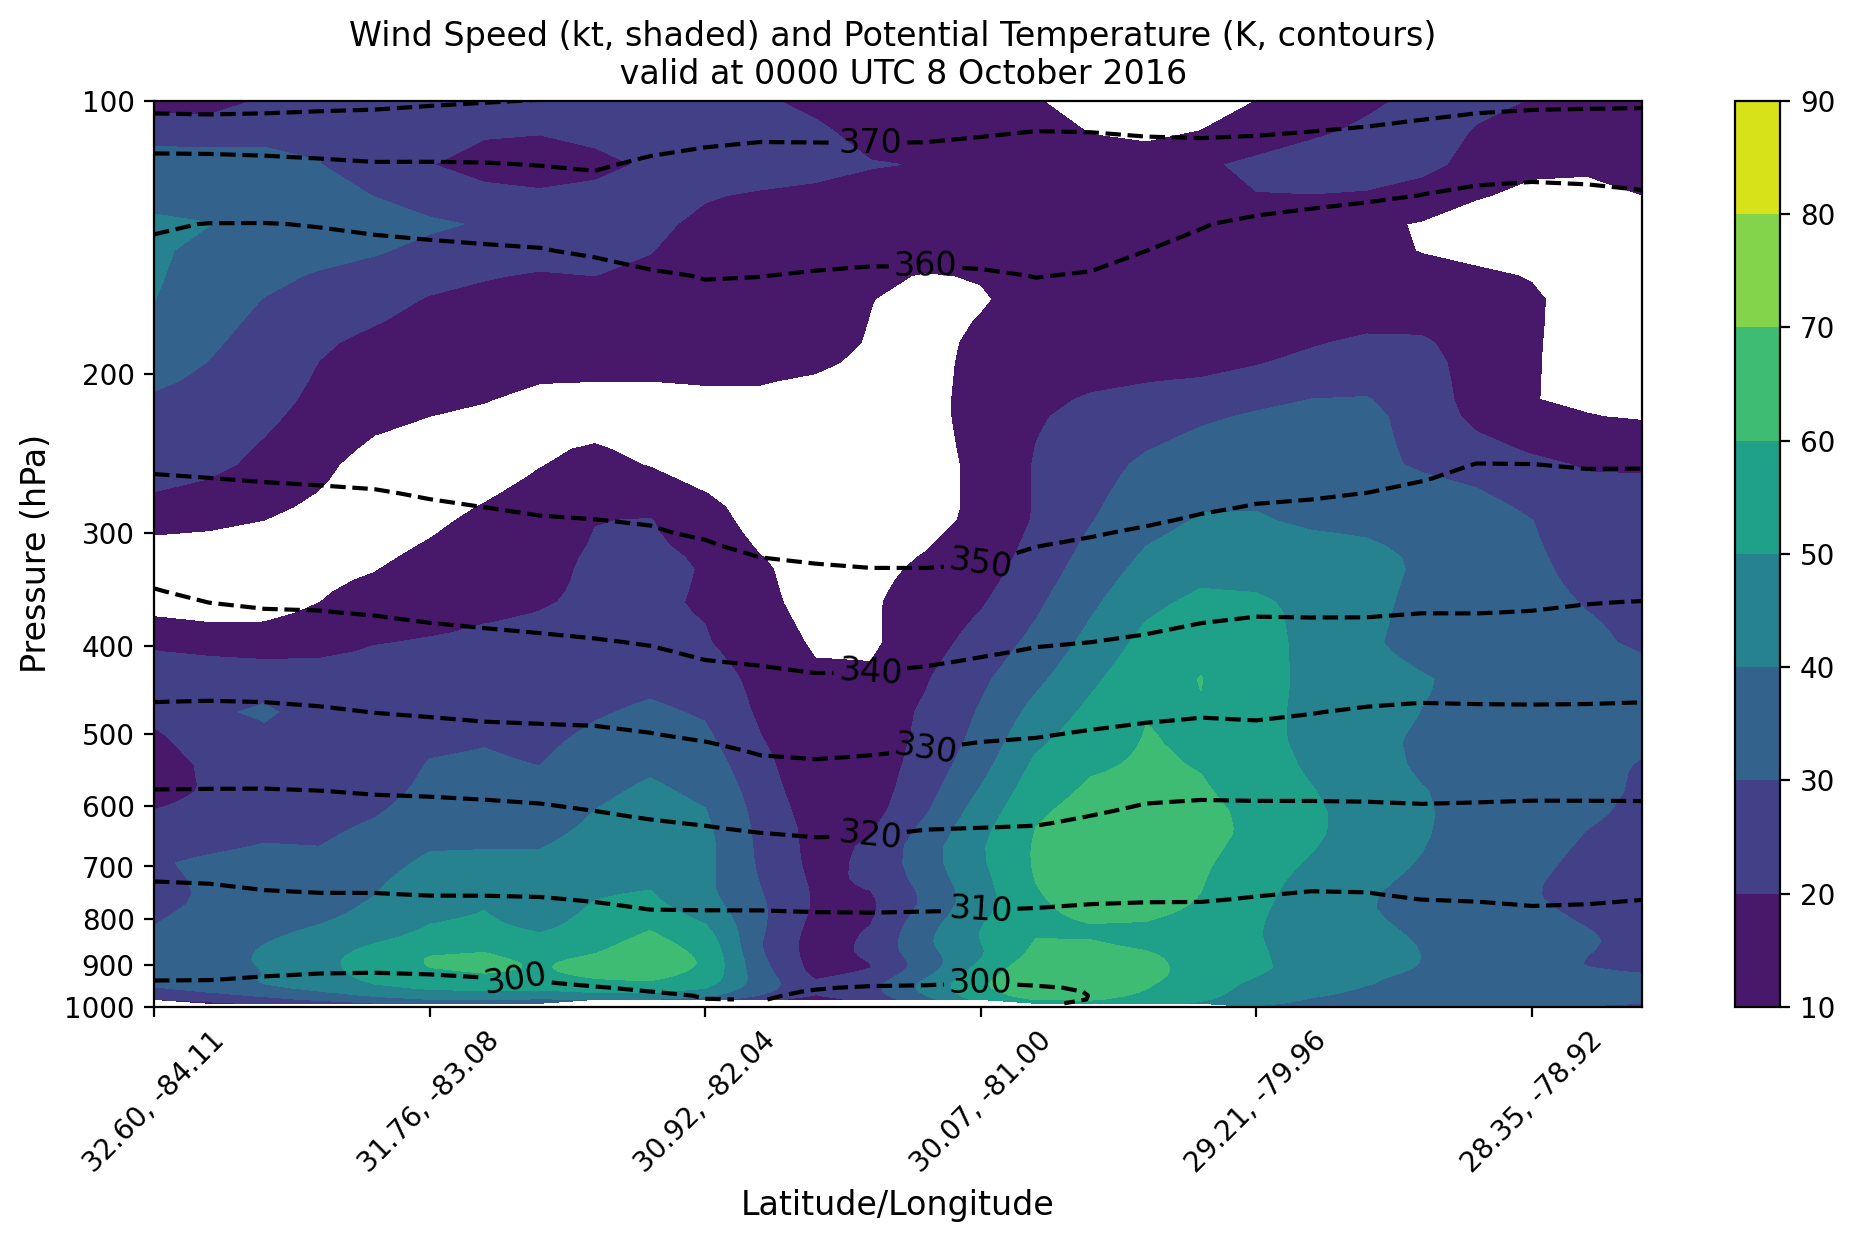

In [12]:
# Create the figure instance (12" wide by 6" tall,
# 200 dots per inch), then establish the figure's axes.
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

# We use contourf to plot the cross-section data, which
# are stored in the wspd_cross variable defined at the
# end of the previous code block. In addition to the data,
# this variable has two coordinate dimensions of relevance:
# xy_loc, which contains the lat/lon points along the cross-
# section, and vertical, which contains the vertical levels
# for the vertical cross-section.
# The x-axis is a 2-D location. When plotting, however, we
# can only pass in one dimension. We handle this by passing
# in a 1-D array of values from 0 -> N, where N is the number
# of locations along our vertical cross-section. We later loop
# over the location coordinates to get lat/lon information for
# labeling the x-axis.
# The y-axis is pressure. We can get this from wspd_cross's
# vertical coordinate.
# All fields are converted from their default xarray fields
# to numpy arrays for ease of plotting. The numpy arrays do
# not have descriptive metadata and thus are well-suited for
# basic plotting operations such as those here.
# We specify contour levels from 10 (inclusive) to 100
# (exclusive) by 10 kt.
# We specify that the plot should use the viridis colormap.
# More info on colormaps:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
coord_pairs = to_np(wspd_cross.coords["xy_loc"])
wspd_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(wspd_cross["vertical"]), 
                            to_np(wspd_cross),np.arange(10.,100.,10.), cmap=get_cmap("viridis"))

# Add a colorbar.
plt.colorbar(wspd_contours, ax=ax)

# Add black contours for potential temperature. As with wind
# speed, we pass a 1-D array from 0 -> N for the x-dimension,
# then pass in the vertical levels for the y-dimension. We
# specify vertical levels from 270 K (inclusive) to 400 K
# (exclusive) by 10 K.
theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(270.,400.,10.),colors='black',
                           linestyles='dashed')
plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")

# This set of code structures our x-axis ticks and their labels.
# It relies on the coord_pairs set of x/y, lat/lon coordinate
# information defined a few lines above. First, we create an
# array from 0 -> N to generically define the axis tick marks.
# Next, we loop over the coord_pairs variable to extract out
# the lat/lon information (using its latlon_str helper function,
# defined in wrf-python's CoordPairs module). These positions,
# which will end up being our tick labels, are stored to x_labels.
# Finally, we set the tick mark locations and tick labels,
# where ::5 for each indicates all values from start to end
# (the :: part) by 5. You may need to tweak this depending on
# how long of a cross-section you have. Note that the tick
# labels are rotated slightly for display purposes.
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)

# This set of code structures our y-axis ticks and their labels.
# We first set the y-axis to be logarithmic rather than linear.
# Next, we set how the logarithmic axis labels should be structured,
# using scalars rather than powers of 10. Once we have
# done that, we define ten y-axis ticks from 100 to 1000 hPa.
# Finally, we set the y-axis limits - in this case, 1000-100 hPa.
ax.set_yscale('symlog')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks(np.linspace(100, 1000, 10))
ax.set_ylim(1000, 100)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Pressure (hPa)", fontsize=12)

# Title the plot and then display it. Note the \n
# operate to split the title over two lines.
plt.title("Wind Speed (kt, shaded) and Potential Temperature (K, contours) \n valid at 0000 UTC 8 October 2016")
plt.show()